# Environment Setup and Imports

In [5]:
# Install or upgrade the numexpr package, which is used by pandas for efficient numerical expressions
!pip install --upgrade numexpr

# Import necessary libraries from SageMaker for model training and deployment
import sagemaker
from sagemaker import get_execution_role  # Get the IAM role for the SageMaker session
from sagemaker.image_uris import retrieve  # Retrieve the Docker image URI for a specific model
from sagemaker.estimator import Estimator  # Estimator class for model training

# Import boto3 library for interacting with AWS services
import boto3
from botocore.exceptions import ClientError

# Import pandas for data manipulation and analysis
import pandas as pd

# Import json for working with JSON data
import json

# Import matplotlib.pyplot for creating visualizations
import matplotlib.pyplot as plt

# Import seaborn for statistical data visualization
import seaborn as sns

# Data Exploration

In [6]:
# Load the OnlineRetail.csv data into a pandas DataFrame
df_onlineretail = pd.read_csv('OnlineRetail.csv')

# Display the first few rows of the df_onlineretail DataFrame
print("First few rows of the DataFrame:")
print(df_onlineretail.head())

First few rows of the DataFrame:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2009 7:45   6.95      13085.0  United Kingdom  
1  12/1/2009 7:45   6.75      13085.0  United Kingdom  
2  12/1/2009 7:45   6.75      13085.0  United Kingdom  
3  12/1/2009 7:45   2.10      13085.0  United Kingdom  
4  12/1/2009 7:45   1.25      13085.0  United Kingdom  


In [7]:
# Display the number of rows and columns in the df_onlineretail DataFrame
print("\nShape of the DataFrame (rows, columns):")
print(df_onlineretail.shape)


Shape of the DataFrame (rows, columns):
(1067371, 8)


In [8]:
# Drop the specified columns from df_onlineretail
columns_to_drop = ['Invoice', 'StockCode', 'Description', 'Customer ID', 'Country']
df_onlineretail.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows of the df_onlineretail DataFrame
print("First few rows of the DataFrame:")
print(df_onlineretail.head())

First few rows of the DataFrame:
   Quantity     InvoiceDate  Price
0        12  12/1/2009 7:45   6.95
1        12  12/1/2009 7:45   6.75
2        12  12/1/2009 7:45   6.75
3        48  12/1/2009 7:45   2.10
4        24  12/1/2009 7:45   1.25


In [9]:
# Display a concise summary of the df_onlineretail DataFrame
print("\nSummary of the DataFrame:")
print(df_onlineretail.info())


Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Quantity     1067371 non-null  int64  
 1   InvoiceDate  1067371 non-null  object 
 2   Price        1067371 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.4+ MB
None


In [10]:
# Convert the 'InvoiceDate' column to datetime format
df_onlineretail['InvoiceDate'] = pd.to_datetime(df_onlineretail['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Display a concise summary of the df_onlineretail DataFrame to verify the datetime format
print("\nSummary of the DataFrame after converting InvoiceDate to datetime:")
print(df_onlineretail.info())


Summary of the DataFrame after converting InvoiceDate to datetime:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Quantity     1067371 non-null  int64         
 1   InvoiceDate  1067371 non-null  datetime64[ns]
 2   Price        1067371 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 24.4 MB
None


In [11]:
# Calculate the number of missing values in each column
missing_values = df_onlineretail.isnull().sum()

# Print the number of missing values for each column
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
Quantity       0
InvoiceDate    0
Price          0
dtype: int64


In [12]:
# Filter out rows with negative prices or quantities
negative_prices = df_onlineretail[df_onlineretail['Price'] < 0]
negative_quantities = df_onlineretail[df_onlineretail['Quantity'] < 0]

# Print rows with negative prices
if not negative_prices.empty:
    print("\nRows with negative Prices:")
    print(negative_prices)
else:
    print("\nThere are no negative Prices.")

# Print rows with negative quantities
if not negative_quantities.empty:
    print("\nRows with negative Quantities:")
    print(negative_quantities)
else:
    print("\nThere are no negative quantities.")


Rows with negative Prices:
        Quantity         InvoiceDate     Price
179403         1 2010-04-29 13:36:00 -53594.36
276274         1 2010-07-19 11:24:00 -44031.79
403472         1 2010-10-20 12:04:00 -38925.87
825444         1 2011-08-12 14:51:00 -11062.06
825445         1 2011-08-12 14:52:00 -11062.06

Rows with negative Quantities:
         Quantity         InvoiceDate   Price
178           -12 2009-12-01 10:33:00    2.95
179            -6 2009-12-01 10:33:00    1.65
180            -4 2009-12-01 10:33:00    4.25
181            -6 2009-12-01 10:33:00    2.10
182           -12 2009-12-01 10:33:00    2.95
...           ...                 ...     ...
1065910       -11 2011-12-09 09:57:00    0.83
1067002        -1 2011-12-09 10:28:00  224.69
1067176        -5 2011-12-09 11:57:00   10.95
1067177        -1 2011-12-09 11:58:00    1.25
1067178        -5 2011-12-09 11:58:00    1.25

[22950 rows x 3 columns]


In [13]:
# Keep only rows with non-negative prices and quantities
df_onlineretail = df_onlineretail[(df_onlineretail['Price'] >= 0) & (df_onlineretail['Quantity'] >= 0)]

# Print the number of rows removed due to negative prices or quantities
print("\nNumber of rows removed due to negative prices or quantities:", len(negative_prices) + len(negative_quantities))


Number of rows removed due to negative prices or quantities: 22955


In [14]:
import matplotlib.pyplot as plt

# Data Preparation for DeepAR

# Calculate the sales by multiplying the quantity and price for each row
df_onlineretail['Sales'] = df_onlineretail['Quantity'] * df_onlineretail['Price']

# Group the DataFrame by the date component of 'InvoiceDate', summing the 'Sales' for each day, and reset the index
daily_sales = df_onlineretail.groupby(df_onlineretail['InvoiceDate'].dt.floor('D'))['Sales'].sum().reset_index()

# Display the daily sales data
print("Daily Sales Data:")
print(daily_sales)

Daily Sales Data:
    InvoiceDate      Sales
0    2009-12-01   54513.50
1    2009-12-02   63352.51
2    2009-12-03   74037.91
3    2009-12-04   40732.92
4    2009-12-05    9803.05
..          ...        ...
599  2011-12-05   88741.96
600  2011-12-06   56713.21
601  2011-12-07   75439.16
602  2011-12-08   82495.00
603  2011-12-09  200938.60

[604 rows x 2 columns]


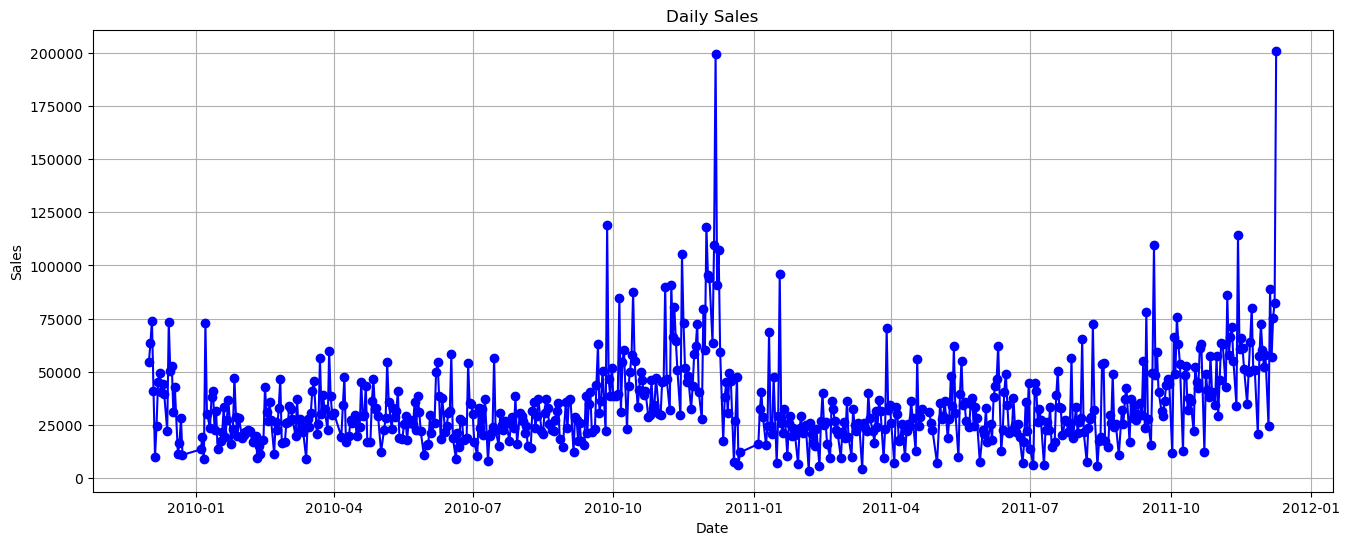

In [15]:
# Plot the daily sales data with markers for each data point

# Create a new figure for the plot with a specified size
plt.figure(figsize=(16, 6))

# 'InvoiceDate' is on the x-axis, 'Sales' is on the y-axis
# Marker style is set to 'o' (circle), line color is set to blue, and line style is set to solid
plt.plot(daily_sales['InvoiceDate'], daily_sales['Sales'], marker='o', color='b', linestyle='-')

# Set the title of the plot
plt.title('Daily Sales')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Sales')

# Add gridlines to the plot
plt.grid(True)

# Display the plot
plt.show()

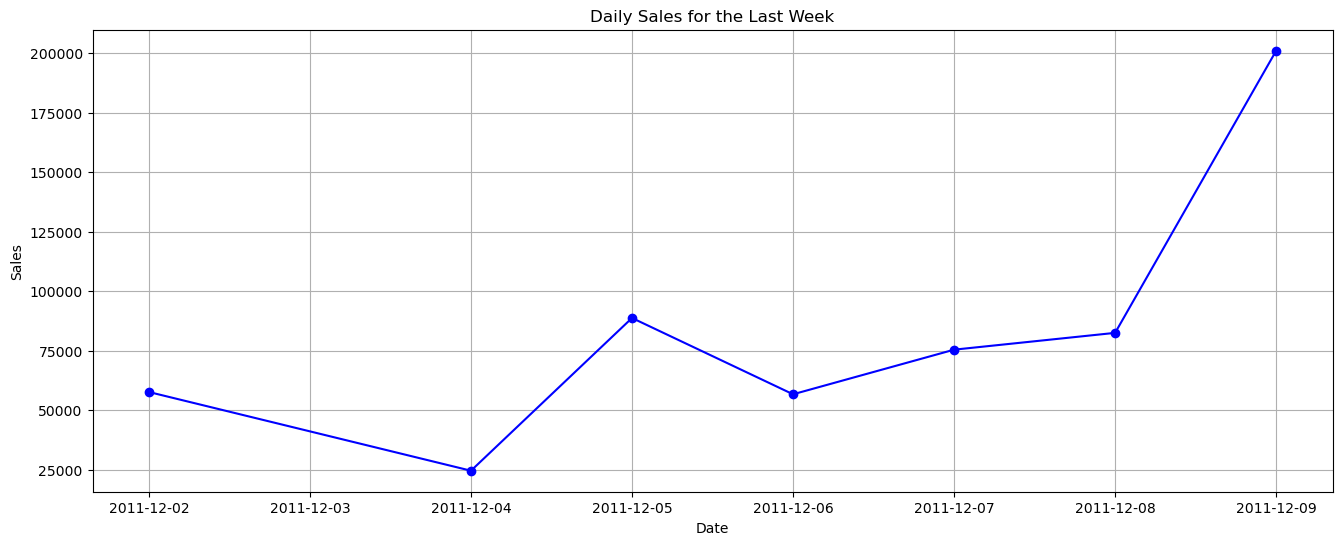

In [16]:
# Plot the daily sales data for the last week with markers for each data point

# Slice the daily_sales DataFrame to include only the last week's worth of data
last_week_sales = daily_sales.tail(7)

# Create a new figure for the plot with a specified size
plt.figure(figsize=(16, 6))

# 'InvoiceDate' is on the x-axis, 'Sales' is on the y-axis
# Marker style is set to 'o' (circle), line color is set to blue, and line style is set to solid
plt.plot(last_week_sales['InvoiceDate'], last_week_sales['Sales'], marker='o', color='b', linestyle='-')

# Set the title of the plot
plt.title('Daily Sales for the Last Week')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Sales')

# Add gridlines to the plot
plt.grid(True)

# Display the plot
plt.show()


# Data Preparation for DeepAR Model Training

In [17]:
# Define a function to convert a pandas Series to a JSON object for DeepAR
def series_to_json_obj(series):
    """
    Converts a pandas Series to a JSON object for DeepAR.

    Parameters:
    series (pandas.Series): The time series data.

    Returns:
    dict: A JSON object with "start" and "target" keys.
    """
    # DeepAR expects each time series to be a JSON object with "start" and "target" keys
    return {"start": str(series.index[0]), "target": list(series)}

# Convert the 'InvoiceDate' column to string format for compatibility with DeepAR
daily_sales['InvoiceDate'] = daily_sales['InvoiceDate'].dt.strftime('%Y-%m-%d')

# Split the daily_sales DataFrame into training and testing data
# For example, use the first 80% of the data for training and the remaining 20% for testing
split_index = int(len(daily_sales) * 0.8)
train_data = daily_sales.iloc[:split_index]
test_data = daily_sales.iloc[split_index:]

# Convert the training data to JSON format for DeepAR
train_series_json = train_data.set_index('InvoiceDate')['Sales'].pipe(series_to_json_obj)

# Convert the test data to JSON format for DeepAR
test_series_json = test_data.set_index('InvoiceDate')['Sales'].pipe(series_to_json_obj)

# Save the training data JSON object to a file
with open('train_data.json', 'w') as f:
    json.dump(train_series_json, f)

# Save the test data JSON object to a file
with open('test_data.json', 'w') as f:
    json.dump(test_series_json, f)

# SageMaker Session and Environment Setup

In [18]:
# Create a SageMaker session for managing interactions with the SageMaker environment
sagemaker_session = sagemaker.Session()

# Retrieve the execution role for the current SageMaker notebook instance
role = get_execution_role()

# Retrieve the AWS region name from the SageMaker session
region = sagemaker_session.boto_region_name

# Specify the DeepAR container
image_uri = retrieve('forecasting-deepar', region)

# Define the default Amazon S3 bucket for the SageMaker session
bucket = sagemaker_session.default_bucket()

# Define the prefix for the S3 key where data will be stored
prefix = 'sagemaker/onlineretail/basic-prediction'

# Define the path to the local training data file
local_train = 'train_data.json'

# Define the path to the local validation data file
local_validation = 'test_data.json'

# Upload the local training data file to the specified S3 bucket and prefix, returning the S3 URI
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)

# Upload the local validation data file to the specified S3 bucket and prefix, returning the S3 URI
test_uri = sagemaker_session.upload_data(local_validation, bucket=bucket, key_prefix=prefix)

# Print the execution role ARN to the console
print("Execution Role ARN:", role)

# Print the AWS region name to the console
print("AWS Region:", region)

# Print the S3 URI for the training data to the console
print("Training Data S3 URI:", train_uri)

# Print the S3 URI for the validation data to the console
print("Validation Data S3 URI:", test_uri)


Execution Role ARN: arn:aws:iam::992382709141:role/LabRole
AWS Region: us-east-1
Training Data S3 URI: s3://sagemaker-us-east-1-992382709141/sagemaker/onlineretail/basic-prediction/train_data.json
Validation Data S3 URI: s3://sagemaker-us-east-1-992382709141/sagemaker/onlineretail/basic-prediction/test_data.json


# Estimator Configuration for DeepAR Algorithm Training

In [19]:
from sagemaker.estimator import Estimator

# Define an Estimator for the DeepAR algorithm in SageMaker
deepar_estimator = Estimator(
    sagemaker_session=sagemaker_session,  # Specify the SageMaker session
    image_uri=image_uri,  # Specify the container image URI for the DeepAR algorithm
    role=role,  # Specify the IAM role ARN used by SageMaker
    instance_count=1,  # Specify the number of instances to use for training
    instance_type='ml.m5.large',  # Specify the instance type for training
    output_path='s3://{}/output'.format(bucket),  # Specify the S3 location for saving the model artifacts and output
    base_job_name='onlineretail-deepar-forecasting'  # Specify the base job name for the training job
)

# Set hyperparameters for the DeepAR algorithm
deepar_estimator.set_hyperparameters(
    time_freq='D',  # Specify the time frequency of the data (e.g., 'D' for daily)
    context_length=30,  # Specify the length of the context used for training (e.g., 30 days)
    prediction_length=7,  # Specify the length of the prediction horizon (forecasting 7 days into the future)
    epochs=20,  # Specify the number of training epochs
    early_stopping_patience=10,  # Specify the number of epochs with no improvement before early stopping
    num_dynamic_feat='auto',  # Automatically detect dynamic features (if any)
    cardinality='auto'  # Automatically detect the cardinality of categorical features (if any)
)

# Model Training with DeepAR Estimator

In [16]:
# Define data channels for training the DeepAR estimator, mapping 'train' and 'test' keys to the S3 URIs of the training and test data
data_channels = {
    'train': train_uri,
    'test': test_uri
}

# Fit the DeepAR estimator using the specified data channels
deepar_estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: onlineretail-deepar-forecasting-2024-02-24-16-46-24-878


2024-02-24 16:46:25 Starting - Starting the training job...
2024-02-24 16:46:39 Starting - Preparing the instances for training...
2024-02-24 16:47:21 Downloading - Downloading input data...
2024-02-24 16:47:51 Downloading - Downloading the training image..................
2024-02-24 16:50:52 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[02/24/2024 16:50:58 INFO 140066464745280] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience

# Model Deployment to SageMaker Endpoint

In [20]:
# Specify the endpoint name
endpoint_name = 'online-retail-endpoint-basic'

# Specify the endpoint configuration name
endpoint_config_name = 'online-retail-endpoint-basic'

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

In [21]:
# Check if the endpoint configuration already exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

Endpoint configuration "online-retail-endpoint-basic" does not exist.


In [22]:
# Check if the endpoint already exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" deleted.')
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')
    else:
        raise

Endpoint "online-retail-endpoint-basic" does not exist.


In [23]:
# Deploy the trained model to an endpoint
predictor = deepar_estimator.deploy(
    initial_instance_count=1,  # Specify the initial number of instances for the endpoint
    instance_type='ml.m5.large',  # Specify the instance type for the endpoint
    serializer=sagemaker.serializers.JSONSerializer(),  # Specify the serializer for the input data
    deserializer=sagemaker.deserializers.JSONDeserializer(),  # Specify the deserializer for the output data
    endpoint_name=endpoint_name,  # Specify the name of the endpoint
)

# Print the endpoint name and endpoint configuration name
print(f'Endpoint name: {predictor.endpoint_name}')
print(f'Endpoint configuration name: {endpoint_config_name}')

INFO:sagemaker:Creating model with name: onlineretail-deepar-forecasting-2024-02-24-16-56-04-939
INFO:sagemaker:Creating endpoint-config with name online-retail-endpoint-basic
INFO:sagemaker:Creating endpoint with name online-retail-endpoint-basic


-------!Endpoint name: online-retail-endpoint-basic
Endpoint configuration name: online-retail-endpoint-basic


# Preparing Prediction Input for DeepAR Model

In [ ]:
# Define the endpoint name
endpoint_name = 'online-retail-endpoint-basic'

# Set the prediction length and start date
prediction_length = 7
prediction_start_date = pd.Timestamp('2011-12-03')

# Prepare the prediction input without categorical or dynamic features
prediction_input = {
    "instances": [{
        "start": str(daily_sales['InvoiceDate'].min()),
        "target": daily_sales['Sales'].tolist() + [0] * prediction_length
    }],
    "configuration": {"num_samples": 100, "output_types": ["mean", "quantiles"], "quantiles": ["0.1", "0.9"]}
}

# Invoke the endpoint for prediction
sagemaker_runtime = boto3.client('sagemaker-runtime')
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(prediction_input)
)

# Parse the prediction response
predictions = json.loads(response['Body'].read().decode())
predicted_means = predictions['predictions'][0]['mean']
predicted_quantiles = predictions['predictions'][0]['quantiles']
predicted_lower_quantile = predicted_quantiles['0.1']
predicted_upper_quantile = predicted_quantiles['0.9']

# Create a DataFrame for the predicted sales
predicted_dates = pd.date_range(start=prediction_start_date, periods=prediction_length, freq='D')
predicted_sales = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Sales': predicted_means,
    'Lower Quantile': predicted_lower_quantile,
    'Upper Quantile': predicted_upper_quantile
})

# Display the predicted sales
print(predicted_sales)

In [ ]:
# Convert 'InvoiceDate' to datetime type
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])

# Filter the historical data to include only the last 30 days
last_30_days_sales = daily_sales[daily_sales['InvoiceDate'] >= (daily_sales['InvoiceDate'].max() - pd.Timedelta(days=30))]

# Plot the daily sales for the last 30 days
plt.figure(figsize=(16, 6))
plt.plot(last_30_days_sales['InvoiceDate'], last_30_days_sales['Sales'], marker='o', linestyle='-', label='Historical Sales')

# Plot the predicted mean sales
plt.plot(predicted_dates, predicted_means, label='Predicted Mean Sales')

# Plot the predicted quantiles as a shaded area
plt.fill_between(predicted_dates, predicted_lower_quantile, predicted_upper_quantile, color='gray', alpha=0.5, label='Predicted 80% Confidence Interval')

# Add labels and title
plt.title('Daily Sales with Prediction for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Delete the Endpoint and Endpoint Config

In [ ]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")
